# 1. SETTINGS

In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

In [2]:
# warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# pandas options
pd.set_option("display.max_columns", None)

# 2. IMPORT

In [4]:
# import datasets 
data = pd.read_csv("../data/prepared/data_v3_80_100.csv", compression = "gzip")

In [5]:
# check data
print("Dimensions:", data.shape)
data.head()

Dimensions: (9262054, 179)


,PredictionIdx,CustomerIdx,IsinIdx,BuySell,CustomerInterest,Week,Recency1,Recency2,Recency3,Recency4,Recency5,Recency6,Frequency1,Frequency2,Frequency3,Frequency4,Frequency5,Frequency6,Month,Asset Managers & Hedge Funds,Asset Owners,Banks and Intermediaries,Corporation,Official Institution - OI,Americas,Asia Pacific,"Europe, Middle East and Africa",FLOW G10,FLOW LOCAL MARKET,SAS & COVERED BONDS,A,A+,A-,AA,AA+,AA-,AAA,B,B+,B-,BB,BB+,BB-,BBB,BBB+,BBB-,C,C+,CC,CC+,CC-,CCC,CCC+,CCC-,D,DD+,DDD,DDD+,NR,Currency_trend,SSE,DAX,EUROSTOXX,VSTOXX,FTSE100,HSI,NIKKEI,DOWJONES_INDU,SP500,VIX,FX_USD.ARS,FX_USD.AUD,FX_USD.BRL,FX_USD.CAD,FX_USD.CHF,FX_USD.CNO,FX_USD.CNY,FX_USD.EUR,FX_USD.GBP,FX_USD.HKD,FX_USD.IDR,FX_USD.JPY,FX_USD.NOK,FX_USD.SGD,FX_USD.TRY,FX_USD.ZAR,MoneyMarket_ARS3M,MoneyMarket_AUD3M,MoneyMarket_CAD3M,MoneyMarket_CHF3M,MoneyMarket_CNO3M,MoneyMarket_CNY3M,MoneyMarket_EUR3M,MoneyMarket_GBP3M,MoneyMarket_HKD3M,MoneyMarket_IDR3M,MoneyMarket_JPY3M,MoneyMarket_NOK3M,MoneyMarket_SGD3M,MoneyMarket_TRY3M,MoneyMarket_USD3M,MoneyMarket_ZAR3M,Swap_ARS10Y,Swap_ARS2Y,Swap_ARS5Y,Swap_AUD10Y,Swap_AUD2Y,Swap_AUD30Y,Swap_AUD5Y,Swap_BRL10Y,Swap_BRL2Y,Swap_BRL5Y,Swap_CAD10Y,Swap_CAD2Y,Swap_CAD30Y,Swap_CAD5Y,Swap_CHF10Y,Swap_CHF2Y,Swap_CHF30Y,Swap_CHF5Y,Swap_CNH10Y,Swap_CNH2Y,Swap_CNH30Y,Swap_CNH5Y,Swap_CNO10Y,Swap_CNO2Y,Swap_CNO30Y,Swap_CNO5Y,Swap_CNY10Y,Swap_CNY2Y,Swap_CNY30Y,Swap_CNY5Y,Swap_EUR10Y,Swap_EUR2Y,Swap_EUR30Y,Swap_EUR5Y,Swap_GBP10Y,Swap_GBP2Y,Swap_GBP30Y,Swap_GBP5Y,Swap_HKD10Y,Swap_HKD2Y,Swap_HKD30Y,Swap_HKD5Y,Swap_IDR10Y,Swap_IDR2Y,Swap_IDR30Y,Swap_IDR5Y,Swap_JPY10Y,Swap_JPY2Y,Swap_JPY30Y,Swap_JPY5Y,Swap_NOK10Y,Swap_NOK2Y,Swap_NOK30Y,Swap_NOK5Y,Swap_SGD10Y,Swap_SGD2Y,Swap_SGD30Y,Swap_SGD5Y,Swap_TRY10Y,Swap_TRY2Y,Swap_TRY5Y,Swap_USD10Y,Swap_USD2Y,Swap_USD30Y,Swap_USD5Y,Swap_ZAR10Y,Swap_ZAR2Y,Swap_ZAR30Y,Swap_ZAR5Y,MeanPrice,StdPrice,MeanYield,StdYield,MeanZScore,StdZScore,YieldMarktDelta,ZScoreMarktDelta
0,NaN,0,21856,Buy,0.0,101,40.0,NaN,NaN,10.0,2.0,2.0,0.000000,0.000000,0.000000,0.050000,2.0,10.0,5,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,23.1600,-111.818,-9.096,1.91098,-49.286,151.196,135.969,74.378,-8.001,1.108,-0.001164,0.00460,-0.003510,0.005505,0.000858,0.000218,0.000260,0.00454,0.00888,0.000002,-2.800000e-07,-0.000084,0.001200,0.000985,-0.004065,0.001145,-0.003065,0.004617,0.002122,-0.001800,0.226,0.229831,-0.000374,-0.011578,0.027275,0.025754,-0.006916,0.022000,-0.043531,-0.041184,0.005035,-0.001800,0.238493,0.963386,1.557914,0.041818,0.021925,0.022358,0.061412,0.161291,0.025486,0.153157,0.004679,0.021746,-0.007479,-0.001873,0.025403,0.007797,0.034490,0.014812,0.238922,0.242905,0.238966,0.234892,0.243923,0.251907,0.243965,0.241894,0.226721,0.238680,0.226889,0.225648,0.015311,-0.007997,0.029411,-0.008800,-0.015244,-0.012471,-0.009235,-0.029899,0.050859,0.021663,0.037470,0.023756,-0.001219,-0.003611,-0.000532,-0.001762,-0.007905,-0.005025,-0.062434,-0.004070,0.069869,0.043280,0.072887,0.053818,-0.024190,-0.035241,-0.044785,-0.016944,0.001283,0.167739,0.085684,0.023390,0.002997,0.028760,0.006479,-0.004000,-0.020000,0.033000,-0.024000,104.741067,1.42108,4.032965,5.854152,2.982566,3.715215,0.982838,1.358983
1,NaN,0,21856,Buy,0.0,102,40.0,NaN,NaN,11.0,1.0,1.0,0.000000,0.000000,0.000000,0.047619,3.0,11.0,5,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,-50.4526,387.806,105.228,-4.89466,95.150,-39.204,196.490,336.774,35.158,-1.406,-0.000682,0.00223,0.002123,0.008174,0.001280,0.000161,0.000188,0.00536,0.00939,-0.000008,9.600000e-07,-0.000067,0.001063,0.002004,-0.000498,0.001428,0.405907,0.005274,0.006554,0.007040,-0.057,-0.062017,-0.002012,-0.004924,0.036163,0.057999,0.010742,0.006000,-0.016184,-0.068295,0.015969,0.000000,1.558637,1.459520,3.278017,0.057117,-0.021341,0.072258,0.007853,-0.076281,-0.203063,-0.076401,0.067571,0.030620,0.091545,0.046593,0.082836,0.031570,0.100353,0.050862,0.122000,0.022000,0.122000,0.064000,0.122000,0.016000,0.122000,0.061

# 3. PREPARATIONS

In [ ]:
# check NA
#data.isnull().sum()

In [6]:
# list of features
excluded_features = ["PredictionIdx", "CustomerIdx", "IsinIdx", "BuySell", "Week", "CustomerInterest"]
features = [var for var in data.columns if var not in excluded_features]
len(features)

173

In [7]:
### drop high recency

# drop from train only
data = data[(data.Week == 121) | (data.Recency1 < data.Recency1.max())]

In [8]:
### data partitioning

# training
X_train = data.loc[data.Week < 120, features]
y_train = data.loc[data.Week < 120].CustomerInterest

# validation
X_valid = data.loc[data.Week == 120, features]
y_valid = data.loc[data.Week == 120].CustomerInterest

# test set
test = data.loc[data.Week == 121]

# 4. MODELING - STAGE 1

## LOGISTIC REGRESSION

In [ ]:
# preparations
#losses = []
#costs = [1, 2, 3]

In [ ]:
# modeling loop
#for c in costs:
#    print(f'Training for c = {c}...')
#    lr = LogisticRegression(C = c)
#    lr = lr.fit(X_train, y_train)
#    probs = lr.predict_proba(X_valid)[:,1]
#    loss = roc_auc_score(y_valid, probs)
#    print(f'- AUC for c = {c} = {loss}')
#    losses.append(loss)

In [ ]:
# extract the best C
#cost = costs[np.argmax(losses)]
#print("Best C =", cost)

## LIGHT GBM

In [21]:
### PARAMETERS

# parallel settings
cores = 16

# learner settings
metric   = "auc"
verbose  = 10
stopping = 100

# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = 7000,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_alambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = 42,
                         num_threads      = cores)

In [22]:
# train lightGBM
gbm = gbm.fit(X_train, y_train, 
              eval_set = [(X_train, y_train), (X_valid, y_valid)], 
              eval_metric = metric, verbose = verbose, 
              early_stopping_rounds = stopping)
    
# save number of iterations
num_iters = gbm.best_iteration_  

### RESULTS
# k = 8,  train = last 20 weeks, drop 80 weeks, only recency & frequency:           0.780024 (0.75749 LB)
# k = 57, train = last 20 weeks, drop 80 weeks, added dummies & bond data:          0.782063 (0.76356 LB)
# k = 59, train = last 20 weeks, drop 80 weeks, additional recency and frequency:   0.781909 ()
# k = 175, train = last 20 weeks, drop 80 week, additional macro indices:           0.78875  (0.77218 LB)
# k = 175, train = last 20 weeks, drop 80 week, additional macro indices: 7000 iterations 0.837796 (0.78297 LB)

# k = 57, train = last 20 weeks, drop 30 weeks, added 50 weeks for RF computation:  0.815764 ()
# k = 61, train = last 20 weeks, drop 30 weeks, more weeks and 6 RF features:       0.817509 (0.77096 LB)
# k = 61, train = last 20 weeks, drop 0 weeks, no new features:                     0.832469 (0.77214 LB)
# k = 61, train = last 40 weeks, drop 0 weeks, no new features:                     0. ()

Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.771684	valid_1's auc: 0.779767
[20]	training's auc: 0.772636	valid_1's auc: 0.780894
[30]	training's auc: 0.773294	valid_1's auc: 0.781344
[40]	training's auc: 0.774133	valid_1's auc: 0.781396
[50]	training's auc: 0.774994	valid_1's auc: 0.782568
[60]	training's auc: 0.775377	valid_1's auc: 0.782627
[70]	training's auc: 0.775736	valid_1's auc: 0.782909
[80]	training's auc: 0.776234	valid_1's auc: 0.783082
[90]	training's auc: 0.77652	valid_1's auc: 0.78336
[100]	training's auc: 0.776891	valid_1's auc: 0.783753
[110]	training's auc: 0.777168	valid_1's auc: 0.783969
[120]	training's auc: 0.777371	valid_1's auc: 0.7842
[130]	training's auc: 0.777525	valid_1's auc: 0.784518
[140]	training's auc: 0.777499	valid_1's auc: 0.78441
[150]	training's auc: 0.777568	valid_1's auc: 0.7845
[160]	training's auc: 0.77768	valid_1's auc: 0.784808
[170]	training's auc: 0.777802	valid_1's auc: 0.784917
[180]	training's au

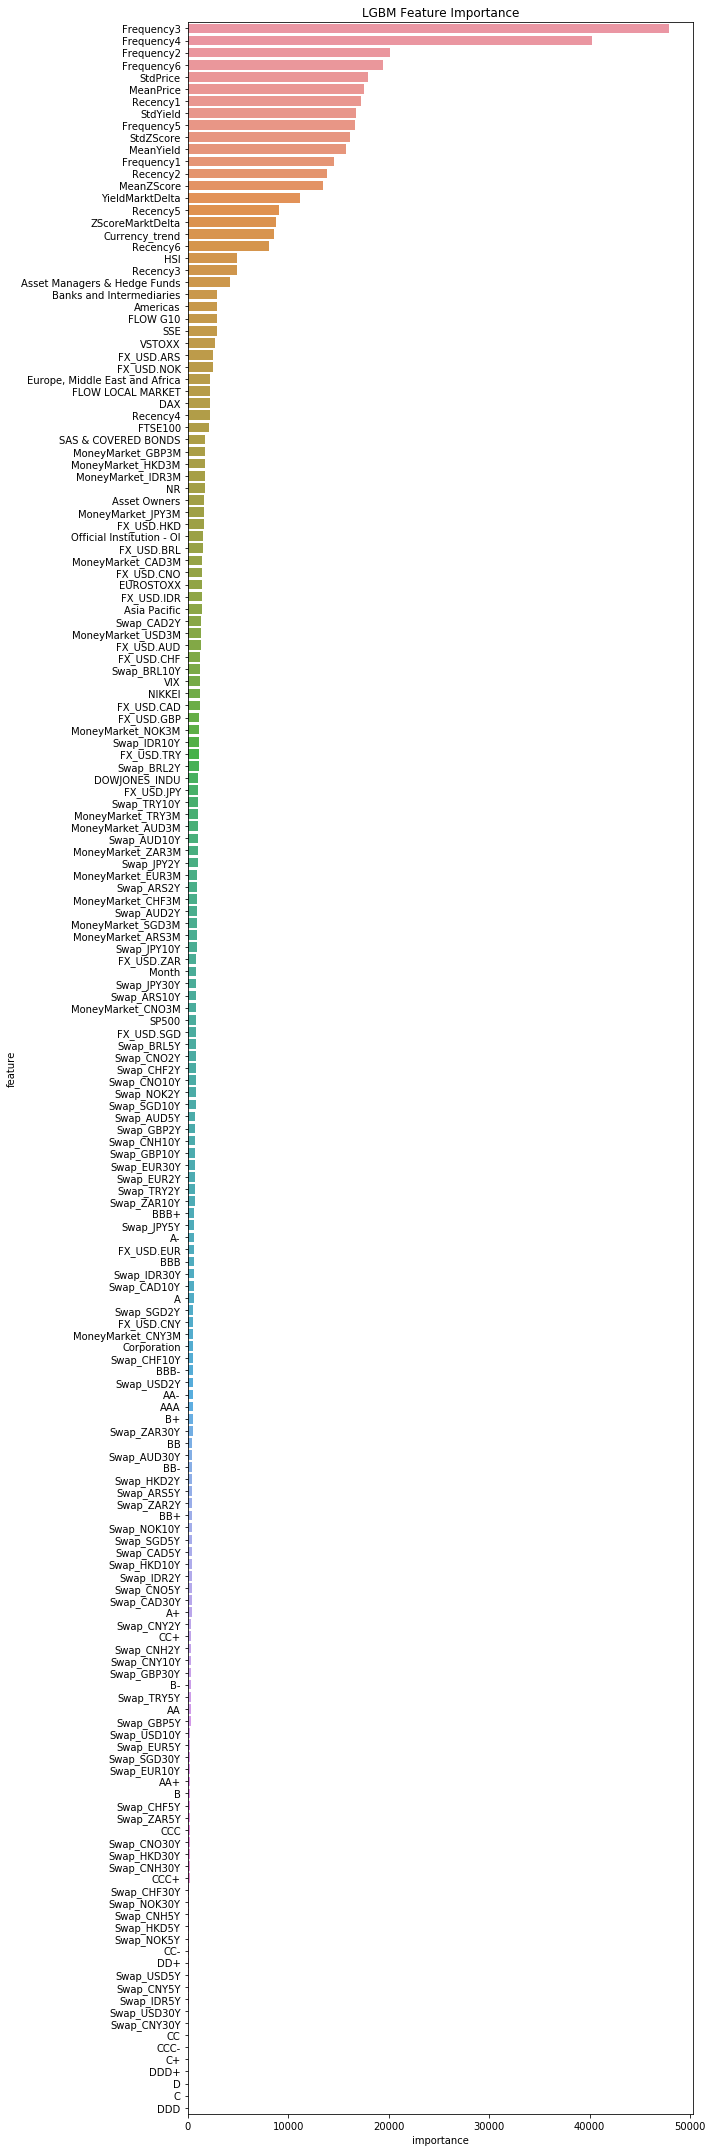

In [23]:
##### VARIABLE IMPORTANCE

# load variable importance
importance = pd.DataFrame()
importance["feature"] = features
importance["importance"] = gbm.feature_importances_

# plot variable importance
plt.figure(figsize = (10, 30))
sns.barplot(x = "importance", y = "feature", data = importance.sort_values(by = "importance", ascending = False))
plt.title('LGBM Feature Importance')
plt.tight_layout()
plt.savefig("../var_importance2.pdf")

# 5. MODELING - STAGE 2

In [24]:
# use full data as train
X_train = data.loc[data.Week <= 120, features]
y_train = data.loc[data.Week <= 120].CustomerInterest

## LOGISTIC REGRESSION

In [ ]:
# retrain model with the best C
#print(f'Training for c = {cost}...')
#lr = LogisticRegression(C = cost)
#lr = lr.fit(X_train, y_train)

In [ ]:
# predict test set
#test["CustomerInterestLOG"] = lr.predict_proba(test[features])[:,1]

## LIGHT GBM

In [25]:
### retrain model with the best iters

# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = num_iters,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_alambda      = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = 42,
                         num_threads      = cores)

# train lightGBM
gbm = gbm.fit(X_train, y_train, 
              eval_set = [(X_train, y_train)], 
              eval_metric = metric, verbose = verbose)

[10]	training's auc: 0.771684
[20]	training's auc: 0.772636
[30]	training's auc: 0.773294
[40]	training's auc: 0.774133
[50]	training's auc: 0.774994
[60]	training's auc: 0.775377
[70]	training's auc: 0.775736
[80]	training's auc: 0.776234
[90]	training's auc: 0.77652
[100]	training's auc: 0.776891
[110]	training's auc: 0.777168
[120]	training's auc: 0.777371
[130]	training's auc: 0.777525
[140]	training's auc: 0.777499
[150]	training's auc: 0.777568
[160]	training's auc: 0.77768
[170]	training's auc: 0.777802
[180]	training's auc: 0.777795
[190]	training's auc: 0.7778
[200]	training's auc: 0.777987
[210]	training's auc: 0.778019
[220]	training's auc: 0.778041
[230]	training's auc: 0.778172
[240]	training's auc: 0.778349
[250]	training's auc: 0.778651
[260]	training's auc: 0.778865
[270]	training's auc: 0.779011
[280]	training's auc: 0.779356
[290]	training's auc: 0.779596
[300]	training's auc: 0.779941
[310]	training's auc: 0.780194
[320]	training's auc: 0.780433
[330]	training's auc:

In [26]:
# predict test set
test["CustomerInterestLGB"] = gbm.predict_proba(test[features], num_iteration = num_iters)[:, 1]

# 6. SUBMISSION

In [16]:
# check rank correlation with the best submission
from scipy.stats import spearmanr
best = pd.read_csv("../submissions/data_v2_30_lgb_val08175.csv")
spearmanr(test["CustomerInterestLGB"], best.CustomerInterest)

FileNotFoundError: File b'../submissions/data_v2_30_lgb_val08175.csv' does not exist

In [27]:
# export CSV
subm = test[["PredictionIdx", "CustomerInterestLGB"]]
subm.columns =["PredictionIdx", "CustomerInterest"]
subm.to_csv("../submissions/data_v3_80_100_lgb_7000it_0837796.csv", index = False, float_format = "%.8f")

In [28]:
subm

,PredictionIdx,CustomerInterest
396,8aa59bcc4c,0.002801
397,f75813c763,0.002397
398,70926ea584,0.003102
399,6238f6b829,0.002008
400,4035f80dc7,0.008600
401,8e42836830,0.003654
402,aa7e7cad3b,0.001620
403,5b7c737d76,0.001857
404,a7e745f758,0.006040
405,0f05140efc,0.005277
